In [1]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import os
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from dataset import LRSDataset, collate_student
from student_model import GPT2LatentReasoningStudent

In [3]:
json_path = "../data/gsm8k_aug_train.jsonl"
teacher_pkl = "/run/determined/NAS1/public/chengjintao/saved_teacher_hiddens/0824_teacher_hidden_states.pkl"
# model_name = "gpt2"
model_name = "/run/determined/NAS1/public/chengjintao/teacher_checkpoints/0824_teacher_best_model.pt"
save_dir = "/run/determined/NAS1/public/chengjintao/student_checkpoints"
batch_size = 16
grad_accum_steps = 8

max_epochs = 8
lr = 3e-3
warmup_ratio = 0.1

max_grad_norm = 1.0
log_steps = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")
TOKENIZER.pad_token = TOKENIZER.eos_token

train_dataset = LRSDataset(json_path, teacher_pkl, TOKENIZER)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_student
)

student = GPT2LatentReasoningStudent(
    model_name=model_name,
    teacher_hidden_size=768,
    alpha_consistency=1
)
student.to(device)

In [ ]:
optimizer = AdamW(student.parameters(), lr=lr, weight_decay=0.01)
# no_decay = ["bias", "ln_", "LayerNorm.weight", "wte", "wpe"]
# decay_params, nodecay_params = [], []
# for n, p in student.named_parameters():
#     if any(k in n for k in no_decay):
#         nodecay_params.append(p)
#     else:
#         decay_params.append(p)
# optimizer = AdamW(
#     [{"params": decay_params, "weight_decay": 0.01},
#      {"params": nodecay_params, "weight_decay": 0.0}],
#     lr=5e-5
# )

from torch.optim.lr_scheduler import LambdaLR
import numpy as np

total_steps = len(train_loader) // grad_accum_steps * max_epochs
warmup_steps = int(total_steps * warmup_ratio)
lr_min_factor = 0.1   # min_lr = 0.1 * base_lr

def lr_lambda(current_step: int):
    if current_step < warmup_steps:
        # 线性warmup: 0 -> 1
        return float(current_step) / float(max(1, warmup_steps))
    # 余弦衰减部分
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine_decay = 0.5 * (1.0 + np.cos(np.pi * progress))
    return lr_min_factor + (1 - lr_min_factor) * cosine_decay

sched = LambdaLR(optimizer, lr_lambda)

In [ ]:
import json
import re

test_path = "../data/gsm8k_aug_test.jsonl"

with open(test_path, "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

def extract_answer(generated_text):

    match = re.search(r'####(.+)<', generated_text)
    if match:
        return match.group(1).strip()
    else:
        return None  # 或抛出异常

cot_end_id = TOKENIZER.encode("####")[0]

def evaluate(model, test_data):
    model.eval()
    model.terminator_id = cot_end_id
    correct = 0

    for i, item in enumerate(tqdm(test_data, desc="Evaluating")):
        question = item["question"]
        reasoning = item["cot_steps"]
        gold = item["answer"]

        prompt = f"{question}"
        inputs = TOKENIZER(prompt, return_tensors="pt").to(device)

        r_text = "||"
        if isinstance(reasoning, (list, tuple)):
            r_text += " ".join([step.strip() for step in reasoning])
        else:
            r_text += reasoning.strip()

        reasoning_steps = len(TOKENIZER(r_text, return_tensors="pt").input_ids[0])
        a_text = f"####{gold}{TOKENIZER.eos_token}"

        with torch.no_grad():
            output_ids = model.generate_answer(
                inputs.input_ids,
                reasoning_steps,
                max_new_tokens=100,
                output_latent=False,
            )

        text = TOKENIZER.decode(output_ids, skip_special_tokens=False)
        pred = extract_answer(text)

        if pred == gold:
            correct += 1

        # 打印前5条用于调试
        # if pred == gold:
        #     print("="*50)
        #     print(f"Full Text: {prompt}{r_text}{a_text}")
        #     print(f"Model Output:\n{text}")
        #     print(f"Predicted Answer: {pred}")

    # 统计准确率
    acc = 100 * correct / len(test_data)
    print(f"Test data Accuracy: {acc:.2f}% ({correct}/{len(test_data)})")

    model.train()

    return acc

In [ ]:
losses = {
    "total": [],
    "nll": [],
    "consistency": [],
}

metrics = {
    "avg_total": [],
    "avg_nll": [],
    "avg_consistency": [],
    "test_acc": [],
}

global_step = 0
student.train()

best_acc = -1.0

for epoch in range(max_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    total_loss_epoch, total_nll_epoch, total_cons_epoch = 0, 0, 0
    num_batches = 0

    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        teacher_r = batch["teacher_reasoning_hiddens"].to(device)
        teacher_a = batch["teacher_answer_hiddens"].to(device)
        q_len = batch["q_len"].to(device)
        r_len = batch["r_len"].to(device)
        a_len = batch["a_len"].to(device)

        # forward
        outputs = student(
            input_ids=input_ids,
            q_len=q_len,
            r_len=r_len,
            a_len=a_len,
            teacher_reasoning_hiddens=teacher_r,
            teacher_answer_hiddens=teacher_a,
        )
        loss = outputs["loss"]

        loss = loss / grad_accum_steps
        loss.backward()

        global_step += 1

        if global_step % grad_accum_steps == 0:
            clip_grad_norm_(student.parameters(), max_grad_norm)
            optimizer.step()
            sched.step()
            optimizer.zero_grad()

        if global_step % log_steps == 0:
            losses["total"].append(outputs["loss"].item())
            losses["nll"].append(outputs["loss_nll"].item())
            losses["consistency"].append(outputs["loss_consistency"].item())

            pbar.set_postfix({
                "total_loss": f"{loss.item()*grad_accum_steps:.4f}",
                "nll": f"{outputs['loss_nll'].item():.4f}",
                "consistency": f"{outputs['loss_consistency'].item():.4f}",
            })

        total_loss_epoch += outputs["loss"].item()
        total_nll_epoch += outputs["loss_nll"].item()
        total_cons_epoch += outputs["loss_consistency"].item()
        num_batches += 1
    
    avg_total = total_loss_epoch / num_batches
    avg_nll = total_nll_epoch / num_batches
    avg_cons = total_cons_epoch / num_batches

    test_acc = evaluate(student, test_data)

    metrics["avg_total"].append(avg_total)
    metrics["avg_nll"].append(avg_nll)
    metrics["avg_consistency"].append(avg_cons)
    metrics["test_acc"].append(test_acc)

    print(f"Epoch {epoch} ✅ avg_total={avg_total:.4f}, avg_nll={avg_nll:.4f}, avg_cons={avg_cons:.4f}, test_acc={test_acc:.4f}")

    # 只保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(save_dir, exist_ok=True)
        ckpt_path = os.path.join(save_dir, f"0907_student_best_model.pt")
        torch.save({
            "epoch": epoch,
            "best_acc": best_acc,
            "model_state": student.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "tokenizer": TOKENIZER,
        }, ckpt_path)
        print(f"✅ Saved new best checkpoint to {ckpt_path} (acc={best_acc:.4f})")
    
    epoch_ckpt_path = os.path.join(save_dir, f"0907_student_epoch_{epoch:03d}_acc_{test_acc:.4f}.pt")
    torch.save({
        "epoch": epoch,
        "test_acc": test_acc,
        "model_state": student.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "tokenizer": TOKENIZER,
    }, epoch_ckpt_path)

Epoch 0:   0%|          | 19/24102 [11:05<234:09:31, 35.00s/it, total_loss=752.4515, nll=5.2719, consistency=747.1796]


KeyboardInterrupt: 

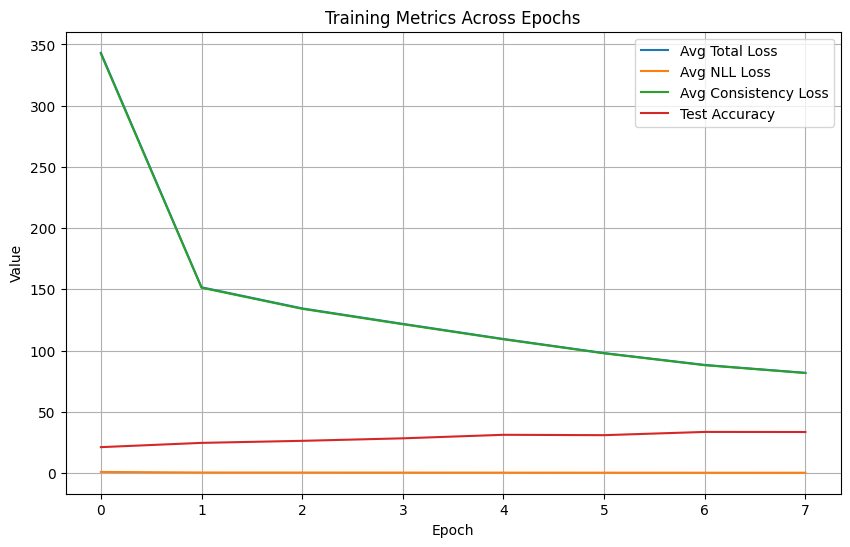

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 假设metrics是一个字典，包含了上述提到的所有键和对应的numpy数组或列表作为值
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Avg Total Loss
axs[0, 0].plot(range(len(metrics["avg_total"])), metrics["avg_total"], 
               color='r', marker='o', linestyle='-', label="Avg Total Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Value")
axs[0, 0].legend()
axs[0, 0].grid(True)
# 设置x轴刻度为整数
axs[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Avg NLL Loss
axs[0, 1].plot(range(len(metrics["avg_nll"])), metrics["avg_nll"], 
               color='g', marker='o', linestyle='-', label="Avg NLL Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Value")
axs[0, 1].legend()
axs[0, 1].grid(True)
# 设置x轴刻度为整数
axs[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Avg Consistency Loss
axs[1, 0].plot(range(len(metrics["avg_consistency"])), metrics["avg_consistency"], 
               color='b', marker='o', linestyle='-', label="Avg Consistency Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Value")
axs[1, 0].legend()
axs[1, 0].grid(True)
# 设置x轴刻度为整数
axs[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Test Accuracy
axs[1, 1].plot(range(len(metrics["test_acc"])), metrics["test_acc"], 
               color='m', marker='o', linestyle='-', label="Test Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()
axs[1, 1].grid(True)
# 设置x轴刻度为整数
axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

# 保存图像
plt.savefig("./student_training_loss_curve_0907.png")

# 显示图像
plt.show()